In [2]:
import numpy as np
import scipy as sp
import functools
from bisect import bisect_left
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
random.seed(42)

In [3]:
class GK01():
    # Comparable tuple data structure
    @functools.total_ordering
    class T():
        def __init__(self, v, g, delta):
            self.v = v
            self.g = g
            self.delta = delta
            
        def __lt__(self, other):
            return self.v < other.v
    
    def __init__(self, epsilon: float):
        self.S = []
        self.n = 0
        self.epsilon = epsilon
        self.interval = int(np.floor(1 / (2 * epsilon)))
    
    # Add observation to data structure
    def add(self, v: int):
        t = self.T(v=v, g=1, delta=int(np.floor(2 * self.epsilon * self.n)))
        index = self.get_insert_index(t)
        if index == 0 or index == len(self.S):
            t.delta = 0;
            
        # ensure that g_i + delta_i <= 2*epsilon*n
        if self.n % self.interval == 0:
            self.compress()
        
        self.S.insert(index, t)
        self.n += 1
    
    # Find index for insertion        
    def get_insert_index(self, t: T):
        index = bisect_left(self.S, t)
        return index
    
    # Merge tuples while possible
    def compress(self):
        for i in range(len(self.S) - 2, 0, -1):
            while i < len(self.S) - 1 and self.delete_el(i):
                continue
                
    # Merge two tuples
    def delete_el(self, i: int):
        t1, t2 = self.S[i], self.S[i + 1]
        
        if t1.delta >= t2.delta and t1.g + t2.g + t2.delta < int(np.floor(2 * self.epsilon * self.n)):
            self.S.pop(i)
            t2.g += t1.g
            return True
        
        return False
    
    # Find the best number representationg particular quantile
    def get_quantile(self, p: float):
        rank = int(np.ceil(p * n))
        margin = int(np.ceil(self.epsilon * self.n))
        
        best = -1
        best_dist = np.inf
        r_min = 0
        for i, t_i in enumerate(self.S):
            r_min += t_i.g
            r_max = r_min + t_i.delta
            if rank - margin <= r_min and r_max <= rank + margin:
                cur_dist = np.abs(rank - (r_min + r_max) / 2)
                if cur_dist < best_dist:
                    best_dist = cur_dist
                    best = i
        if best == -1:
            return('error')
        return self.S[best].v


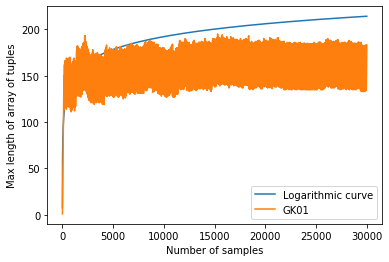

In [65]:
test_stream = list(range(1, 30000))

eps = 0.01
gk01 = GK01(eps)
lengths = []
random.shuffle(test_stream)
for x in test_stream:
    gk01.add(x)
    lengths.append(len(gk01.S))
logarithm = [1/0.05*np.log(eps*n) + 100 for n in list(range(1, 30000))]
ax = plt.plot(list(range(1, 30000)), logarithm)
ax = plt.plot(list(range(1, 30000)), lengths)
plt.legend(['Logarithmic curve', 'GK01'], loc='lower right')
plt.xlabel('Number of samples')
plt.ylabel('Max length of array of tuples')
plt.show()

In [28]:
stream = list(range(100000))
epsilons = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
data = [[] for i in range(len(epsilons))]

for i, epsilon in tqdm(enumerate(epsilons)):
    for j in range(200):
        data[i].append(0)
        gk01 = GK01(epsilon)
        random.shuffle(stream)
        for el in stream:
            gk01.add(el)
            if data[i][j] < len(gk01.S):
                data[i][j] = len(gk01.S)

6it [17:50, 178.40s/it]


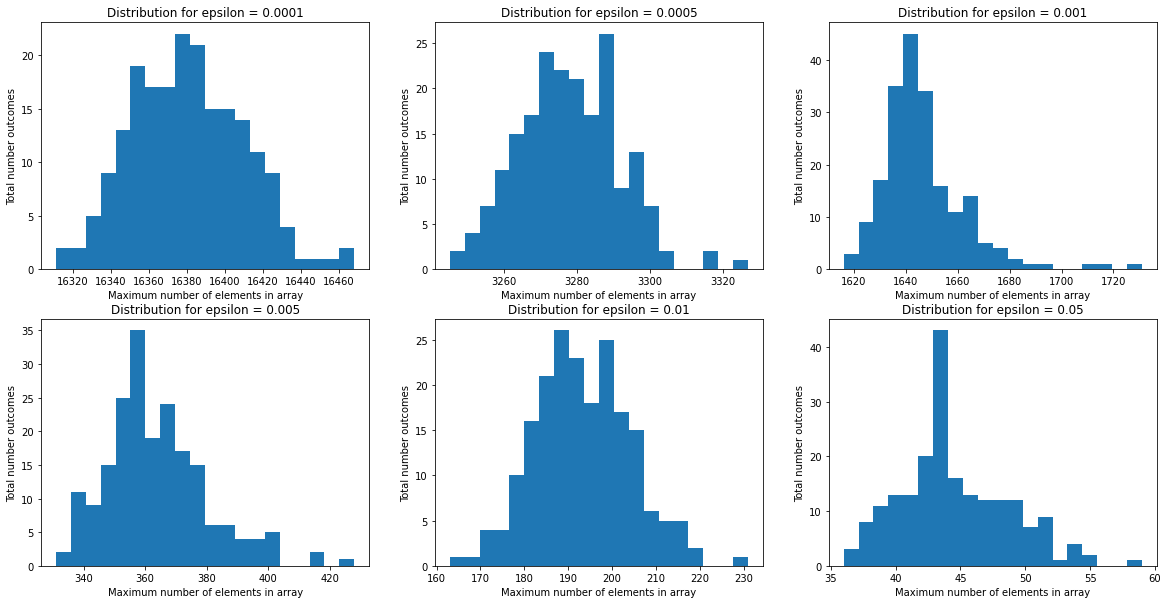

<Figure size 7200x7200 with 0 Axes>

In [42]:
figure, axis = plt.subplots(2, 3, figsize=(20,10))

for x in range(2):
    for y in range(3):
        axis[x, y].hist(data[3*x + y], bins=20)
        axis[x, y].set_title(f"Distribution for epsilon = {epsilons[3*x + y]}")
        axis[x, y].set_ylabel('Total number outcomes')
        axis[x, y].set_xlabel('Maximum number of elements in array')

plt.figure(figsize=(100, 100))
plt.show()